In [1]:
# !pip install transformers accelerate datasets diffusers Pillow==9.4.0

In [2]:
import torchvision.transforms as T
import torch
import random
from datasets import load_dataset, Dataset, DatasetDict
from diffusers import AutoencoderDC
from torch.utils.data import DataLoader
from utils import make_grid, PIL_to_latent, latent_to_PIL, dcae_scalingf
from tqdm import tqdm


/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load CIFAR10 dataset

In [3]:
ds = load_dataset("uoft-cs/cifar10")
print(ds["train"], ds["train"][0])

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
}) {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FCE54A88310>, 'label': 0}


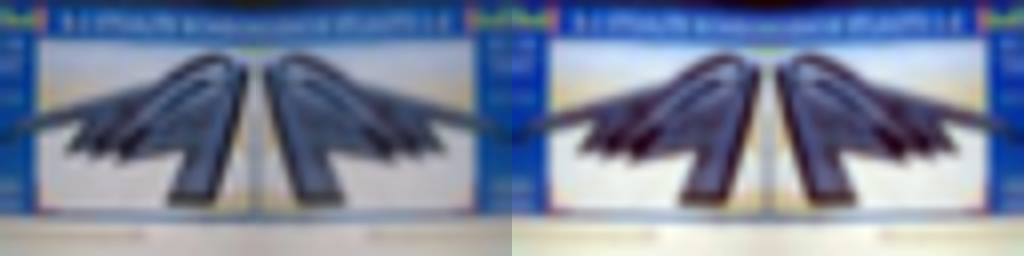

In [4]:
img=ds["train"][2]["img"]
images = []
resizeTo = 64

images.append( img.resize((256,256)) )

def augment(img, do_flip=False, do_contrast=False):
    def noop(x): return x
    transform = T.Compose([
        T.Resize(resizeTo, antialias=True) if resizeTo is not None else skipT,
        T.CenterCrop(resizeTo),
        T.RandomHorizontalFlip(p=1 if do_flip else 0),
        T.RandomAutocontrast(p=1 if do_contrast else 0),
    ])
    return transform(img)

images.append( augment(img, do_flip=True).resize((256,256)) )
images.append( augment(img, do_contrast=True).resize((256,256)) )
images.append( augment(img, do_flip=True, do_contrast=True).resize((256,256)) )

make_grid(images)

# Load DCAE

In [5]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# Batch augment and create dataset

In [6]:
def collate(items):
    labels = [item["label"] for item in items]
    images = [item["img"] for item in items]
    return labels, images

In [1]:
test_run = True
# batch_size = 256
batch_size = 8
resizeTo = 64
dataset_latents = {}
splits=["train", "test"]

for split in splits:
    dataloader = DataLoader(ds[split], batch_size = batch_size, shuffle=False, collate_fn=collate)
    dataset_latents[split]=[]
    
    for labels, images in tqdm(dataloader, f"split {split}"):
        images_batch = []
        for img in images:
            # 4 latents: orig, flipped, autocontrast, flipped+autocontrast
            images_batch.append(augment(img))
            images_batch.append(augment(img, do_flip=True))
            images_batch.append(augment(img, do_contrast=True))
            images_batch.append(augment(img, do_flip=True, do_contrast=True))
        assert len(images_batch) / len(labels) == int(len(images_batch) / len(labels))  # sanity check equal number of augmentations per image
        latents_per_img = len(images_batch) // len(labels)

        # all latents of batch in single tensor -> shape [B * latents_per_img, ..., C, W, H]
        latents = PIL_to_latent(images_batch, dcae).float().cpu()   
    
        for i, img_label in enumerate(labels):
            # slice tensor, only latents of current image
            img_latents = latents[i * latents_per_img:(i+1) * latents_per_img]  # shape [latents_per_img, ..., C, W, H]
            # if test_run: print(latents.shape)
            dataset_latents[split].append({
                "label": img_label,
                "num_latents": latents_per_img,
                "latent": img_latents.numpy(),
            })
        if test_run: break

NameError: name 'DataLoader' is not defined

split train
0 torch.Size([4, 32, 2, 2])


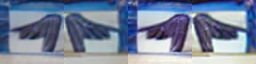

7 torch.Size([4, 32, 2, 2])


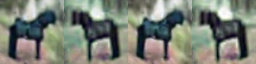

0 torch.Size([4, 32, 2, 2])


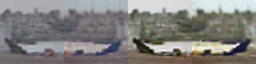

2 torch.Size([4, 32, 2, 2])


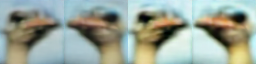

2 torch.Size([4, 32, 2, 2])


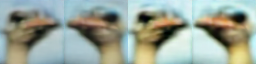

2 torch.Size([4, 32, 2, 2])


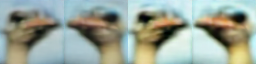

0 torch.Size([4, 32, 2, 2])


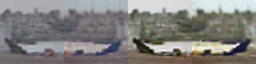

2 torch.Size([4, 32, 2, 2])


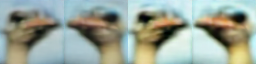

2 torch.Size([4, 32, 2, 2])


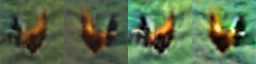

2 torch.Size([4, 32, 2, 2])


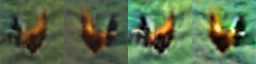

0 torch.Size([4, 32, 2, 2])


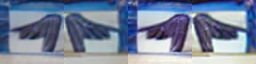

2 torch.Size([4, 32, 2, 2])


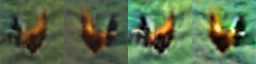

split test
6 torch.Size([4, 32, 2, 2])


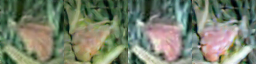

6 torch.Size([4, 32, 2, 2])


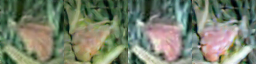

0 torch.Size([4, 32, 2, 2])


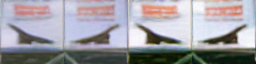

1 torch.Size([4, 32, 2, 2])


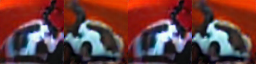

6 torch.Size([4, 32, 2, 2])


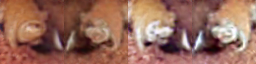

1 torch.Size([4, 32, 2, 2])


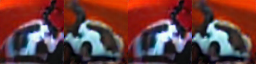

8 torch.Size([4, 32, 2, 2])


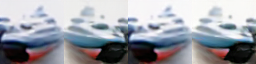

6 torch.Size([4, 32, 2, 2])


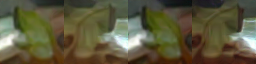

0 torch.Size([4, 32, 2, 2])


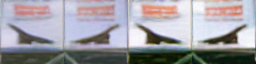

6 torch.Size([4, 32, 2, 2])


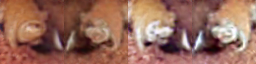

6 torch.Size([4, 32, 2, 2])


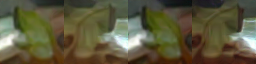

3 torch.Size([4, 32, 2, 2])


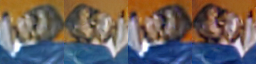

In [25]:
# check a few samples
num_samples = 12
dataset = dataset_latents
for split in splits:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(num_samples)]:
        latent = dataset[split][idx]["latent"]
        label = dataset[split][idx]["label"]
        print(label, latent.shape)
        display(
            make_grid(
                latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
            )
        )

# Upload

In [9]:
dataset = DatasetDict({split: Dataset.from_list(dataset_latents[split]) for split in splits})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 256
    })
    test: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 256
    })
})

split train
6


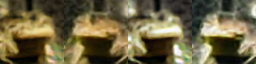

3


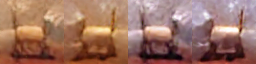

0


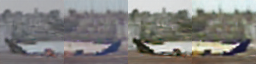

6


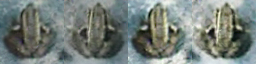

2


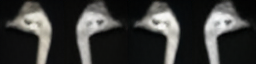

split test
8


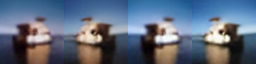

6


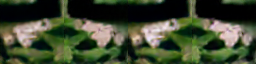

7


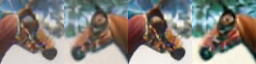

7


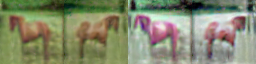

7


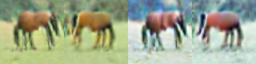

In [10]:
# check a few samples
for split in splits:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(5)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label)
        display(
            make_grid(latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae))
        )

In [11]:
# dataset.push_to_hub("g-ronimo/CIFAR10-64-latents-augmented_dc-ae-f32c32-sana-1.0", private=True, commit_message=model)

In [12]:
latent = dataset["train"][0]["latent"]

In [13]:
type(latent)

list